In [5]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-10



c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


beta_x=10 
beta_y=4

#disp_x=0.12

                                        


ModuleNotFoundError: No module named 'ducktrack'

In [ ]:
#dispersion and space charge parabola

dtk_cooler = dtk.elements.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,B_ratio=B_ratio,
                                         Neutralisation_space_charge=1,Neutralisation_rotation=0)      


r=np.arange(start=-50*1e-2, stop=50*1e-2, step=1e-3)

#beta_diff=dtk_cooler.radial_velocity_dependence(gamma,r,current,beta_rel,r_beam)   
# beta2=beta_diff+beta_rel

dE_E = (1.2e-4*current/(beta_rel**3))*(r/r_beam)**2


E = dtk_cooler.beta_to_kinetic_energy(beta_rel, dtk_cooler.me_ev)# + Pb_m0_MeV_c2 #Mev/c^2
E_diff = dE_E*E
E_tot = E + E_diff
beta2=dtk_cooler.kinetic_energy_to_beta(E_tot, dtk_cooler.me_ev)
#beta_ratio = beta2/beta
beta_diff = beta2-beta_rel

p0 = beta_rel*dtk_cooler.me_ev*gamma
p2 = beta2*dtk_cooler.me_ev*gamma

dp_p=(p2-p0)/p0                                         

Parameters: $I=2.4 A, B=0.060 T, \beta_x=10 m,\beta_y=4,D_x=0.12 m T_\perp=100meV,T_\parallel=1meV,\epsilon_{x}=35*1e-6,\epsilon_{y}=35*1e-6,dp/p=1e-3$

In [6]:
cooling_time = []
num_particles = 1

disp_values = np.linspace(1, 20, num=20)
delta_values = np.linspace(-5e-3, 5e-3, num=10)  # example delta values, adjust as needed

cooling_time = np.zeros((len(disp_values), len(delta_values)))  # initialize empty array to store cooling_time values

for i, disp in enumerate(tqdm(disp_values)):
    for j, delta in enumerate(delta_values):
        disp_x = disp
        cooling_time_found = False

        arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=disp_x,disp_x_1=disp_x,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0)

        delta_single = delta

        dtk_particle = xp.Particles(
                mass0=mass0,
                p0c=p0c,
                x=disp_x*delta_single,
                px=0,
                y=0,
                py=0,
                delta=delta_single,
                zeta=0)

        dtk_cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                B=B,B_ratio=1e-4,
                                                Neutralisation_space_charge=1)

        num_turns = int(1*1e7)
        step = int(num_turns/100)

        
        # loop over turns
        for turn in tqdm(range(num_turns)):
            if dtk_particle.delta < 0.1 * delta_single:
                cooling_time[i, j] = turn * s_per_turn  # store cooling_time value in the corresponding array position
                cooling_time_found = True
                break

            # track particle
            arc.track(dtk_particle)
            dtk_cooler.track(dtk_particle)

        if not cooling_time_found:
            cooling_time[i, j] = turn * s_per_turn  # store cooling_time value in the corresponding array position

# Save arrays to .npz file
np.savez('cooling_time_data.npz', cooling_time=cooling_time, delta_values=delta_values, disp_values=disp_values)




  0%|          | 0/50 [00:05<?, ?it/s]


KeyboardInterrupt: 

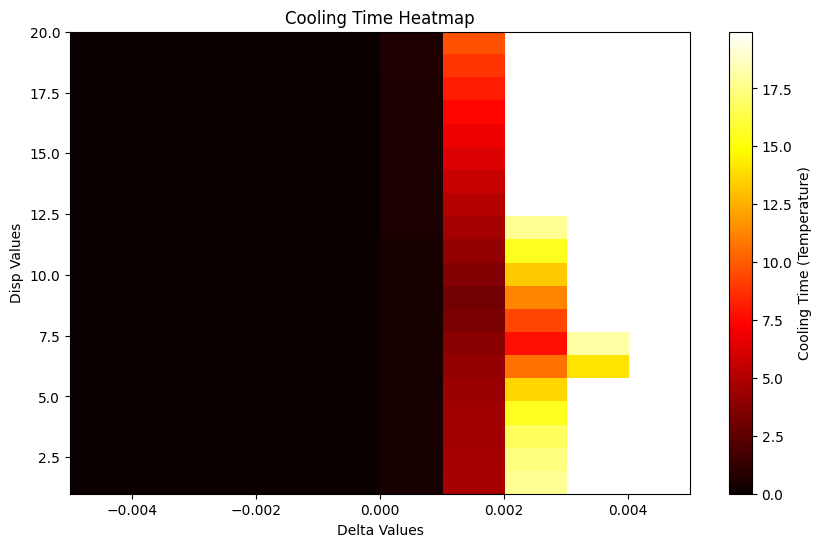

In [8]:
import numpy as np
import matplotlib.pyplot as plt

file='cooling_time_data.npz'

data = np.load(file)

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded the data into the following arrays
disp_values = data['disp_values']
delta_values = data['delta_values']
cooling_time = data['cooling_time']

# Reshape cooling_time list to a 20x10 array
cooling_time = np.reshape(cooling_time, (20, 10))

# Create a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(cooling_time, cmap='hot', aspect='auto', origin='lower',
           extent=[delta_values[0], delta_values[-1], disp_values[0], disp_values[-1]])
plt.colorbar(label='Cooling Time (Temperature)')
plt.xlabel('Delta Values')
plt.ylabel('Disp Values')
plt.title('Cooling Time Heatmap')
plt.show()
